# Домашнее задание на 20 декабря
## Выполнил Шурыгин Сергей

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD # Аналог PCA для разреженных матриц

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score
from sklearn.metrics.cluster import contingency_matrix

# Загрузка
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('fake_job_postings.csv')

target_col = "fraudulent"
text_cols = ["title", "company_profile", "description", "requirements", "benefits"]
cat_cols = ["employment_type", "required_experience", "required_education", "industry", "function", "department", "location"]
bool_cols = ["telecommuting", "has_company_logo", "has_questions"]

# 1.1 Обработка пропусков
df[text_cols] = df[text_cols].fillna("")
df[cat_cols] = df[cat_cols].fillna("Missing")
df[bool_cols] = df[bool_cols].fillna(0)

# 1.2 тексты превращаем в их длины
for col in text_cols:
    df[col + "_len"] = df[col].apply(len)

# Обновляем списки колонок для обучения
num_cols = [c + "_len" for c in text_cols]

#2. Подготовка матрицы признаков (X) и целевой переменной (y)
X_raw = df[num_cols + cat_cols + bool_cols]
y = df[target_col]

print(f"Размер данных: {X_raw.shape}")

Saving fake_job_postings.csv to fake_job_postings.csv
Размер данных: (17880, 15)


In [ ]:

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('bool', 'passthrough', bool_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_cols)
    ]
)

X_processed = preprocessor.fit_transform(X_raw)

print(f"Размерность после OneHotEncoder: {X_processed.shape}")

Размерность после OneHotEncoder: (17880, 4650)


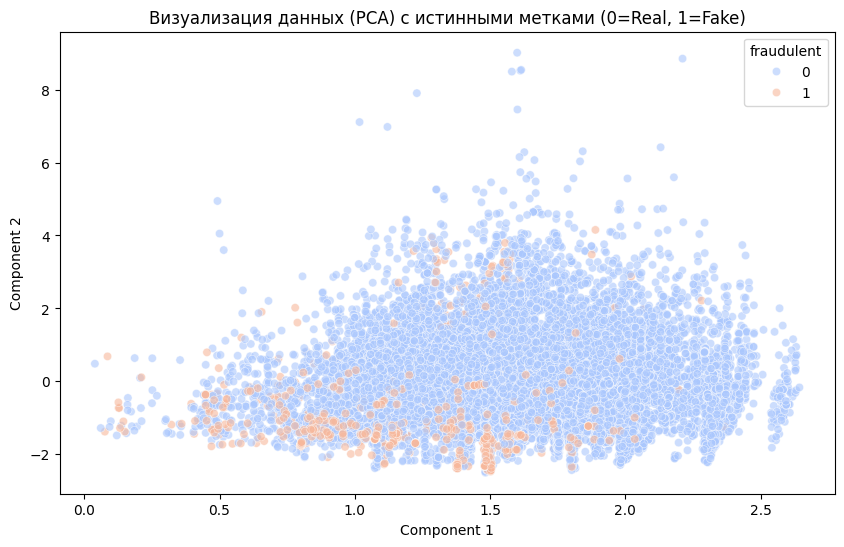

Вывод: видим, что классы сильно перемешаны и не образуют явных отдельных островов в 2D проекции.


In [ ]:
# Используем TruncatedSVD, так как он работает разреженными (является аналогом PCA)
svd = TruncatedSVD(n_components=2, random_state=42)
X_pca = svd.fit_transform(X_processed)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm', alpha=0.6)
plt.title("Визуализация данных с истинными метками (0=Real, 1=Fake)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()    # видим, что классы сильно перемешаны и не образуют явных отдельных островов в 2D проекции

--- Запуск K-Means ---

Матрица сопряженности (K-Means vs True Labels):
[[8708 8306]
 [ 655  211]]
Adjusted Rand Index (качество разбиения): -0.0018


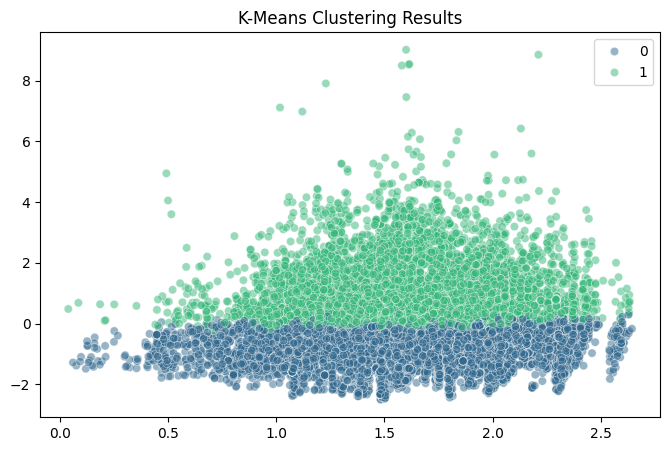

In [ ]:
print(" Запуск K-Means")
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_processed)

print("\nМатрица сопряженности (K-Means vs True Labels):")
# Строки - истинные классы, Столбцы - предсказанные кластеры
print(contingency_matrix(y, kmeans_labels))

ari_kmeans = adjusted_rand_score(y, kmeans_labels)
print(f"качество разбиения: {ari_kmeans:.4f}")

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis', alpha=0.5)
plt.title("K-Means Results")
plt.show()

--- Запуск DBSCAN ---
Найдено кластеров: 3 (метка -1 означает шум)
Распределение меток:
 0    17247
-1      617
 1       16
Name: count, dtype: int64

Матрица сопряженности (DBSCAN vs True Labels):
[[  570 16428    16]
 [   47   819     0]]
Adjusted Rand Index: 0.0208


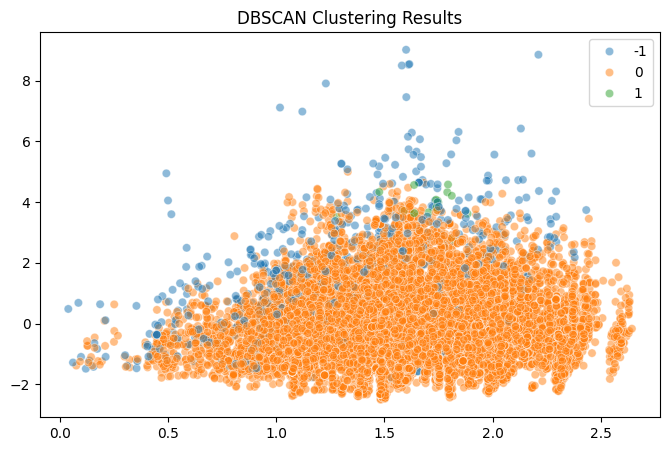

In [ ]:
print("Запуск DBSCAN ")
dbscan = DBSCAN(eps=3.0, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_processed)

unique_labels = np.unique(dbscan_labels)
print(f"Найдено кластеров: {len(unique_labels)} (метка -1 означает шум)")
print(f"Распределение меток:\n{pd.Series(dbscan_labels).value_counts().head()}")

print("\nМатрица сопряженности (DBSCAN vs True Labels):")
print(contingency_matrix(y, dbscan_labels))

ari_dbscan = adjusted_rand_score(y, dbscan_labels)
print(f"качество разбиения: {ari_dbscan:.4f}")

# Визуализация
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_labels, palette='tab10', legend='full', alpha=0.5)
plt.title("DBSCAN Clustering Results")
plt.show()

--- Запуск Agglomerative Clustering ---

Матрица сопряженности (Agglomerative vs True Labels):
[[12292  4722]
 [  595   271]]
Adjusted Rand Index: 0.0062


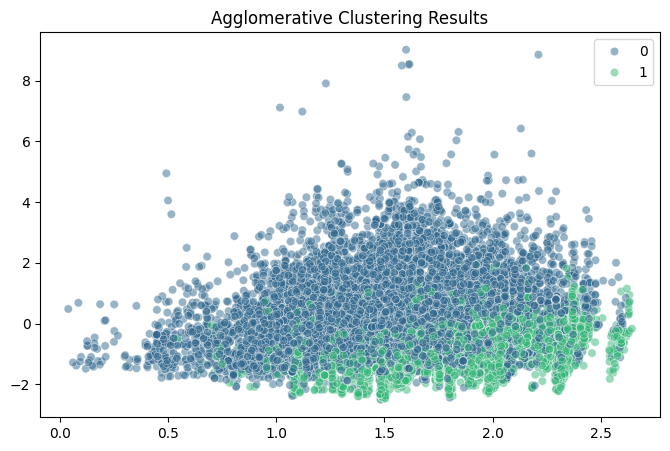

In [ ]:
print(" Запуск Agglomerative Clustering ")
agg = AgglomerativeClustering(n_clusters=2)
try:
    agg_labels = agg.fit_predict(X_processed.toarray())
except Exception as e:
    print("Ошибка памяти")
    # Если памяти мало
    svd_50 = TruncatedSVD(n_components=50, random_state=42)
    X_reduced = svd_50.fit_transform(X_processed)
    agg_labels = agg.fit_predict(X_reduced)

print("\nМатрица сопряженности (Agglomerative vs True Labels):")
print(contingency_matrix(y, agg_labels))

ari_agg = adjusted_rand_score(y, agg_labels)
print(f"качество разбиения: {ari_agg:.4f}")

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=agg_labels, palette='viridis', alpha=0.5)
plt.title("Agglomerative Clustering Results")
plt.show()

## Вывод

Результаты показывают, что задача выявления фейковых вакансий методами кластеризации (обучение без учителя) на текущих признаках не решается
Почему?:

*   Фейковая вакансия выглядит так же, как настоящая: у нее есть заголовок, описание, требования. Геометрически в пространстве признаков (длина текста, категория) фейки не отделены от реальных вакансий расстоянием.
*   Фейков всего ~5% такие маленькие группы часто считаются выбросами или поглощаются крупными кластерами.
* Мы использовали простые признаки. Для этой задачи необходим глубокий анализ текста, чтобы отделить «подозрительный» текст от нормального.



